In [1]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
import numpy as np
import pandas as pd
from rdkit import Chem

import openpyxl
import os
from pathlib import Path


In [9]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data'/'raw'
interim_dir = Path(TOP) / 'data'/'interim'
external_dir = Path(TOP) / 'data'/'external'
figures_dir = Path(TOP) / 'reports'/'figures/'
processed_dir = Path(TOP) / 'data'/'processed'


In [12]:
from torch_geometric.data import Data, Dataset, DataLoader

In [49]:
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torch_scatter import scatter
from torch_geometric.data import Data, Dataset, DataLoader

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem
import math
import random
from copy import deepcopy
import networkx as nx

In [50]:
ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [
    BT.SINGLE, 
    BT.DOUBLE, 
    BT.TRIPLE, 
    BT.AROMATIC
]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]


In [62]:
def remove_subgraph(Graph, center, percent=0.2):
    assert percent <= 1
    G = Graph.copy()
    num = int(np.floor(len(G.nodes)*percent))
    removed = []
    temp = [center]
    
    while len(removed) < num:
        neighbors = []
        if len(temp) < 1:
            break

        for n in temp:
            neighbors.extend([i for i in G.neighbors(n) if i not in temp])      
        for n in temp:
            if len(removed) < num:
                G.remove_node(n)
                removed.append(n)
            else:
                break

        temp = list(set(neighbors))
    return G, removed

In [68]:
class GraphData(Dataset):
    def __init__(self, df):
        """
        GraphData class inheriting from the Dataset class in PyTorch.

        Parameters
        ----------
        df : pandas.DataFrame
            The dataframe containing the SMILES strings.
        """
        self.df = df
        self.valid_indices = self._get_valid_indices()

    def _get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            smiles = row['smiles']
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError(f"Invalid SMILES: {smiles}")
                valid_indices.append(idx)
            except Exception as e:
                print(f"Error processing SMILES {smiles}: {e}")
                continue  # Skip invalid SMILES
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        """
        Returns the graph representation of the molecule.

        Parameters
        ----------
        idx : int
            Index of the valid sample.

        Returns
        -------
        graph : torch_geometric.data.Data
            The graph representation of the molecule.
        """
        # Use valid index to get the actual row from the dataframe
        valid_idx = self.valid_indices[idx]
        row = self.df.iloc[valid_idx]
        smiles = row['smiles']
        
        # Process the valid SMILES string
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        
        N = mol.GetNumAtoms()
        M = mol.GetNumBonds()
        atoms = mol.GetAtoms()
        bonds = mol.GetBonds()

        #########################
        # Get the molecule info #
        #########################
        type_idx = []
        chirality_idx = []
        atomic_number = []
        for atom in mol.GetAtoms():
            type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
            chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
            atomic_number.append(atom.GetAtomicNum())

        x1 = torch.tensor(type_idx, dtype=torch.long).view(-1,1)
        x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1,1)
        x = torch.cat([x1, x2], dim=-1)

        row, col, edge_feat = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)

        ####################
        # Subgraph Masking #
        ####################

        # Construct the original molecular graph from edges (bonds)
        edges = []
        for bond in bonds:
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        molGraph = nx.Graph(edges)
        
        # Get the graph for i and j after removing subgraphs
        start_i, start_j = random.sample(list(range(N)), 2)
        percent_i, percent_j = random.uniform(0, 0.2), random.uniform(0, 0.2)
        G_i, removed_i = remove_subgraph(molGraph, start_i, percent=percent_i)
        G_j, removed_j = remove_subgraph(molGraph, start_j, percent=percent_j)

        atom_remain_indices_i = [i for i in range(N) if i not in removed_i]
        atom_remain_indices_j = [i for i in range(N) if i not in removed_j]
        
        # Only consider bond still exist after removing subgraph
        row_i, col_i, row_j, col_j = [], [], [], []
        edge_feat_i, edge_feat_j = [], []
        G_i_edges = list(G_i.edges)
        G_j_edges = list(G_j.edges)

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            feature = [
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ]
            if (start, end) in G_i_edges or (end, start) in G_i_edges:
                row_i += [start, end]
                col_i += [end, start]
                edge_feat_i.append(feature)
                edge_feat_i.append(feature)
            if (start, end) in G_j_edges or (end, start) in G_j_edges:
                row_j += [start, end]
                col_j += [end, start]
                edge_feat_j.append(feature)
                edge_feat_j.append(feature)
        
        edge_index_i = torch.tensor([row_i, col_i], dtype=torch.long)
        edge_attr_i = torch.tensor(np.array(edge_feat_i), dtype=torch.long)
        edge_index_j = torch.tensor([row_j, col_j], dtype=torch.long)
        edge_attr_j = torch.tensor(np.array(edge_feat_j), dtype=torch.long)

        ############################
        # Random Atom/Edge Masking #
        ############################

        num_mask_nodes_i = max([0, math.floor(0.25*N)-len(removed_i)])
        num_mask_edges_i = max([0, edge_attr_i.size(0)//2 - math.ceil(0.75*M)])
        num_mask_nodes_j = max([0, math.floor(0.25*N)-len(removed_j)])
        num_mask_edges_j = max([0, edge_attr_j.size(0)//2 - math.ceil(0.75*M)])
        mask_nodes_i = random.sample(atom_remain_indices_i, num_mask_nodes_i)
        mask_nodes_j = random.sample(atom_remain_indices_j, num_mask_nodes_j)
        mask_edges_i_single = random.sample(list(range(edge_attr_i.size(0)//2)), num_mask_edges_i)
        mask_edges_j_single = random.sample(list(range(edge_attr_j.size(0)//2)), num_mask_edges_j)
        mask_edges_i = [2*i for i in mask_edges_i_single] + [2*i+1 for i in mask_edges_i_single]
        mask_edges_j = [2*i for i in mask_edges_j_single] + [2*i+1 for i in mask_edges_j_single]

        x_i = deepcopy(x)
        for atom_idx in range(N):
            if (atom_idx in mask_nodes_i) or (atom_idx in removed_i):
                x_i[atom_idx,:] = torch.tensor([len(ATOM_LIST), 0])
        edge_index_final_i = torch.zeros((2, edge_attr_i.size(0) - 2*num_mask_edges_i), dtype=torch.long)
        edge_attr_final_i = torch.zeros((edge_attr_i.size(0) - 2*num_mask_edges_i, 2), dtype=torch.long)
        count = 0
        for bond_idx in range(edge_attr_i.size(0)):
            if bond_idx not in mask_edges_i:
                edge_index_final_i[:,count] = edge_index_i[:,bond_idx]
                edge_attr_final_i[count,:] = edge_attr_i[bond_idx,:]
                count += 1
        data_i = Data(x=x_i, edge_index=edge_index_final_i, edge_attr=edge_attr_final_i)

        x_j = deepcopy(x)
        for atom_idx in range(N):
            if (atom_idx in mask_nodes_j) or (atom_idx in removed_j):
                x_j[atom_idx,:] = torch.tensor([len(ATOM_LIST), 0])
        edge_index_final_j = torch.zeros((2, edge_attr_j.size(0) - 2*num_mask_edges_j), dtype=torch.long)
        edge_attr_final_j = torch.zeros((edge_attr_j.size(0) - 2*num_mask_edges_j, 2), dtype=torch.long)
        count = 0
        for bond_idx in range(edge_attr_j.size(0)):
            if bond_idx not in mask_edges_j:
                edge_index_final_j[:,count] = edge_index_j[:,bond_idx]
                edge_attr_final_j[count,:] = edge_attr_j[bond_idx,:]
                count += 1
        data_j = Data(x=x_j, edge_index=edge_index_final_j, edge_attr=edge_attr_final_j)
        
        return data_i, data_j
        

In [98]:
class GraphData_unaug(Dataset):
    def __init__(self, df):
        """
        GraphData class inheriting from the Dataset class in PyTorch.

        Parameters
        ----------
        df : pandas.DataFrame
            The dataframe containing the SMILES strings.
        """
        self.df = df
        self.valid_indices = self._get_valid_indices()

    def _get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            smiles = row['smiles']
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError(f"Invalid SMILES: {smiles}")
                valid_indices.append(idx)
            except Exception as e:
                print(f"Error processing SMILES {smiles}: {e}")
                continue  # Skip invalid SMILES
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        """
        Returns the graph representation of the molecule.

        Parameters
        ----------
        idx : int
            Index of the valid sample.

        Returns
        -------
        graph : torch_geometric.data.Data
            The graph representation of the molecule.
        """
        # Use valid index to get the actual row from the dataframe
        valid_idx = self.valid_indices[idx]
        row = self.df.iloc[valid_idx]
        smiles = row['smiles']
        
        # Process the valid SMILES string
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        
        N = mol.GetNumAtoms()
        M = mol.GetNumBonds()

        type_idx = []
        chirality_idx = []
        atomic_number = []
        # aromatic = []
        # sp, sp2, sp3, sp3d = [], [], [], []
        # num_hs = []
        for atom in mol.GetAtoms():
            type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
            chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
            atomic_number.append(atom.GetAtomicNum())
            # aromatic.append(1 if atom.GetIsAromatic() else 0)
            # hybridization = atom.GetHybridization()
            # sp.append(1 if hybridization == HybridizationType.SP else 0)
            # sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
            # sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
            # sp3d.append(1 if hybridization == HybridizationType.SP3D else 0)

        # z = torch.tensor(atomic_number, dtype=torch.long)
        x1 = torch.tensor(type_idx, dtype=torch.long).view(-1,1)
        x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1,1)
        x = torch.cat([x1, x2], dim=-1)
        # x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, sp3d, num_hs],
        #                     dtype=torch.float).t().contiguous()
        # x = torch.cat([x1.to(torch.float), x2], dim=-1)

        row, col, edge_feat = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            # edge_type += 2 * [MOL_BONDS[bond.GetBondType()]]
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)

        # random mask a subgraph of the molecule
        num_mask_nodes = max([1, math.floor(0.25*N)])
        num_mask_edges = max([0, math.floor(0.25*M)])
        mask_nodes_i = random.sample(list(range(N)), num_mask_nodes)
        mask_nodes_j = random.sample(list(range(N)), num_mask_nodes)
        mask_edges_i_single = random.sample(list(range(M)), num_mask_edges)
        mask_edges_j_single = random.sample(list(range(M)), num_mask_edges)
        mask_edges_i = [2*i for i in mask_edges_i_single] + [2*i+1 for i in mask_edges_i_single]
        mask_edges_j = [2*i for i in mask_edges_j_single] + [2*i+1 for i in mask_edges_j_single]

        x_i = deepcopy(x)
        for atom_idx in mask_nodes_i:
            x_i[atom_idx,:] = torch.tensor([len(ATOM_LIST), 0])
        edge_index_i = torch.zeros((2, 2*(M-num_mask_edges)), dtype=torch.long)
        edge_attr_i = torch.zeros((2*(M-num_mask_edges), 2), dtype=torch.long)
        count = 0
        for bond_idx in range(2*M):
            if bond_idx not in mask_edges_i:
                edge_index_i[:,count] = edge_index[:,bond_idx]
                edge_attr_i[count,:] = edge_attr[bond_idx,:]
                count += 1
        data_i = Data(x=x_i, edge_index=edge_index_i, edge_attr=edge_attr_i)

        x_j = deepcopy(x)
        for atom_idx in mask_nodes_j:
            x_j[atom_idx,:] = torch.tensor([len(ATOM_LIST), 0])
        edge_index_j = torch.zeros((2, 2*(M-num_mask_edges)), dtype=torch.long)
        edge_attr_j = torch.zeros((2*(M-num_mask_edges), 2), dtype=torch.long)
        count = 0
        for bond_idx in range(2*M):
            if bond_idx not in mask_edges_j:
                edge_index_j[:,count] = edge_index[:,bond_idx]
                edge_attr_j[count,:] = edge_attr[bond_idx,:]
                count += 1
        data_j = Data(x=x_j, edge_index=edge_index_j, edge_attr=edge_attr_j)
        
        return data_i, data_j

In [6]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

In [59]:
class NTXentLoss(torch.nn.Module):

    def __init__(self, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [60]:
criterion = NTXentLoss(batch_size = 512, temperature = 0.1, use_cosine_similarity=True )

In [4]:
num_atom_type = 119 # including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 5 # including aromatic and self-loop edge
num_bond_direction = 3 

In [5]:
class GINEConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GINEConv, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim)
        )
        self.edge_embedding1 = nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = nn.Embedding(num_bond_direction, emb_dim)
        nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        nn.init.xavier_uniform_(self.edge_embedding2.weight.data)

    def forward(self, x, edge_index, edge_attr):
        # add self loops in the edge space
        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))[0]

        # add features corresponding to self-loop edges.
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:,0] = 4 #bond type for self-loop edge
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(edge_attr.dtype)
        edge_attr = torch.cat((edge_attr, self_loop_attr), dim=0)

        edge_embeddings = self.edge_embedding1(edge_attr[:,0]) + self.edge_embedding2(edge_attr[:,1])

        return self.propagate(edge_index, x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)


class GINet(nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat
    Output:
        node representations
    """
    def __init__(self, num_layer=5, emb_dim=300, feat_dim=512, drop_ratio=0, pool='mean'):
        super(GINet, self).__init__()
        self.num_layer = num_layer
        self.emb_dim = emb_dim
        self.feat_dim = feat_dim
        self.drop_ratio = drop_ratio

        self.x_embedding1 = nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = nn.Embedding(num_chirality_tag, emb_dim)
        nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        # List of MLPs
        self.gnns = nn.ModuleList()
        for layer in range(num_layer):
            self.gnns.append(GINEConv(emb_dim))

        # List of batchnorms
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))
        
        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'max':
            self.pool = global_max_pool
        elif pool == 'add':
            self.pool = global_add_pool
        
        self.feat_lin = nn.Linear(self.emb_dim, self.feat_dim)

        self.out_lin = nn.Sequential(
            nn.Linear(self.feat_dim, self.feat_dim), 
            nn.ReLU(inplace=True),
            nn.Linear(self.feat_dim, self.feat_dim//2)
        )

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        h = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        for layer in range(self.num_layer):
            h = self.gnns[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

        h = self.pool(h, data.batch)
        h = self.feat_lin(h)
        out = self.out_lin(h)
        
        return h, out

In [14]:
df1 = pd.read_csv(external_dir/'toxcast_cleaned.csv', index_col = [0])

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train, test = train_test_split(df1, test_size = 0.2)

In [69]:
train_data = GraphData(train)

[12:13:14] Explicit valence for atom # 5 N, 5, is greater than permitted


Error processing SMILES OCC=C1C[NH]2(CC=C)CCC34C2CC1C1=CN2C5C(=CN(C31)C1=C4C=CC=C1)C1CC3C5(CC[NH]3(CC=C)CC1=CCO)C1=C2C=CC=C1: Invalid SMILES: OCC=C1C[NH]2(CC=C)CCC34C2CC1C1=CN2C5C(=CN(C31)C1=C4C=CC=C1)C1CC3C5(CC[NH]3(CC=C)CC1=CCO)C1=C2C=CC=C1


In [70]:
train_loader = DataLoader(train_data, batch_size=512, shuffle=True, drop_last=True)

In [92]:
test_data = GraphData(test)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False, drop_last=True)

/home/grace/anaconda3/envs/pytorch_cuda/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [105]:
rax = (pd.read_csv(interim_dir/'icf_processed_220125.csv')
       .rename(columns = {'QSAR Ready SMILES':'smiles'})
 .query('smiles.notnull()')
)

In [107]:
rax.info()

rax_data = GraphData_unaug(rax)
rax_loader = DataLoader(rax_data, batch_size=1, shuffle=False, drop_last=True)

<class 'pandas.core.frame.DataFrame'>
Index: 755 entries, 0 to 796
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    755 non-null    int64 
 1   Substance Name in Assessment  755 non-null    object
 2   substance_role                755 non-null    object
 3   Approach                      755 non-null    object
 4   dtxsid                        755 non-null    object
 5   Preferred Name                750 non-null    object
 6   CASRN                         753 non-null    object
 7   SMILES                        755 non-null    object
 8   smiles                        755 non-null    object
 9   analogue_evidence_stream      678 non-null    object
 10  use_case                      755 non-null    object
 11  source                        697 non-null    object
dtypes: int64(1), object(11)
memory usage: 76.7+ KB


/home/grace/anaconda3/envs/pytorch_cuda/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
model = GINet()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005, weight_decay=1e-5   )

In [34]:
from torch.optim.lr_scheduler import SequentialLR, CosineAnnealingLR, LambdaLR

# Warm-up for the first 10 epochs
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 10.0 if epoch < 10 else 1.0)

# Cosine decay for the remaining epochs
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# Combine the warm-up and cosine schedulers
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[10])

In [96]:
def validate_model(model, val_loader):
    
    with torch.no_grad():
        model.eval()
        total_loss = 0
        for bn, (xis, xjs) in enumerate(val_loader):
            # Forward pass
            ris, zis = model(xis)
            rjs, zjs = model(xjs)

            # Normalize projections
            zis = F.normalize(zis, dim=1)
            zjs = F.normalize(zjs, dim=1)
            # Compute loss
            loss = criterion(zis, zjs)
            total_loss += loss.item()
        return total_loss / len(val_loader)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, path='best_model.pt', verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change in monitored metric to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Whether to print updates about early stopping.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model saved!")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter}/{self.patience} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Saves the current best model."""
        torch.save(model.state_dict(), self.path)

In [ ]:
# Initialize early stopping
early_stopping = EarlyStopping(patience=10, path="best_model.pt", verbose=True)

for epoch in range(epochs):
    # Training step
    model.train()
    train_loss = 0.0
    for (xis, xjs) in train_loader:
        optimizer.zero_grad()
        xis, xjs = xis.to(device), xjs.to(device)
        loss = model._step(xis, xjs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (xis, xjs) in valid_loader:
            xis, xjs = xis.to(device), xjs.to(device)
            loss = model._step(xis, xjs)
            val_loss += loss.item()
    val_loss /= len(valid_loader)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

    # Check early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered. Training terminated.")
        break

# Load the best model after early stopping
model.load_state_dict(torch.load("best_model.pt"))
print("Loaded the best model based on validation loss.")

In [108]:
epochs = 50
embeddings_list = []
for epoch in range(epochs):
    model.train()  # Ensure model is in training mode

    for bn, (xis, xjs) in enumerate(train_loader):
        # Forward pass
        ris, zis = model(xis)
        rjs, zjs = model(xjs)
        
        # Normalize projections
        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)
        embeddings_list.append((zis, zjs)) 
        # Compute loss
        loss = criterion(zis, zjs)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    val_loss = validate_model(model, test_loader)

    # Step the learning rate scheduler at the end of the epoch
    scheduler.step()

    # Logging (optional, for monitoring purposes)
    current_lr = scheduler.get_last_lr()[0]  # Get current learning rate
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, LR: {current_lr:.6f}, Val Loss: {val_loss:.4f}")

Epoch [1/50], Loss: 2.1079, LR: 0.000397, Val Loss: 2.3312
Epoch [2/50], Loss: 2.1022, LR: 0.000381, Val Loss: 2.2040
Epoch [3/50], Loss: 2.1579, LR: 0.000363, Val Loss: 2.1845
Epoch [4/50], Loss: 1.9882, LR: 0.000346, Val Loss: 2.1657
Epoch [5/50], Loss: 2.0210, LR: 0.000327, Val Loss: 2.2917
Epoch [6/50], Loss: 1.9737, LR: 0.000308, Val Loss: 2.2404
Epoch [7/50], Loss: 1.9767, LR: 0.000289, Val Loss: 2.0947
Epoch [8/50], Loss: 1.9655, LR: 0.000270, Val Loss: 2.0807
Epoch [9/50], Loss: 2.0209, LR: 0.000250, Val Loss: 2.0912
Epoch [10/50], Loss: 2.0704, LR: 0.000230, Val Loss: 2.1109
Epoch [11/50], Loss: 1.9417, LR: 0.000211, Val Loss: 2.0734
Epoch [12/50], Loss: 1.9786, LR: 0.000192, Val Loss: 1.9913
Epoch [13/50], Loss: 1.8583, LR: 0.000173, Val Loss: 2.0192
Epoch [14/50], Loss: 1.9003, LR: 0.000154, Val Loss: 2.0097
Epoch [15/50], Loss: 1.8337, LR: 0.000137, Val Loss: 2.0683
Epoch [16/50], Loss: 1.8051, LR: 0.000119, Val Loss: 1.9500
Epoch [17/50], Loss: 1.8729, LR: 0.000103, Val Lo

In [157]:
embeddings_list[0][0].shape

torch.Size([512, 128])

In [109]:
torch.save(model.state_dict(), 'model_weights_txcst.pth') 

In [165]:
def extract_embeddings(model, test_loader):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch_idx, (xis, _) in enumerate(test_loader):
            
            
            # Forward pass
            _, zis = model(xis)  # Extract embeddings
            
            # Normalize
            zis = torch.nn.functional.normalize(zis, dim=1)

            # Debugging shapes
            print(f"Before transpose: Batch {batch_idx}, zis.shape = {zis.shape}")

            # Fix shape if needed
            if zis.shape[0] == 1 and zis.shape[1] == 128:  
                zis = zis.T  # Transpose to (batch_size, 512)

            print(f"After transpose: Batch {batch_idx}, zis.shape = {zis.shape}")

            # Convert to NumPy
            all_embeddings.append(zis.cpu().numpy())  

    # Stack all embeddings
    all_embeddings = np.vstack(all_embeddings)
    print(f"Final embeddings shape: {all_embeddings.shape}")  



In [166]:
rax_embeddings = extract_embeddings(model, rax_loader)

Before transpose: Batch 0, zis.shape = torch.Size([1, 128])
After transpose: Batch 0, zis.shape = torch.Size([128, 1])
Before transpose: Batch 1, zis.shape = torch.Size([1, 128])
After transpose: Batch 1, zis.shape = torch.Size([128, 1])
Before transpose: Batch 2, zis.shape = torch.Size([1, 128])
After transpose: Batch 2, zis.shape = torch.Size([128, 1])
Before transpose: Batch 3, zis.shape = torch.Size([1, 128])
After transpose: Batch 3, zis.shape = torch.Size([128, 1])
Before transpose: Batch 4, zis.shape = torch.Size([1, 128])
After transpose: Batch 4, zis.shape = torch.Size([128, 1])
Before transpose: Batch 5, zis.shape = torch.Size([1, 128])
After transpose: Batch 5, zis.shape = torch.Size([128, 1])
Before transpose: Batch 6, zis.shape = torch.Size([1, 128])
After transpose: Batch 6, zis.shape = torch.Size([128, 1])
Before transpose: Batch 7, zis.shape = torch.Size([1, 128])
After transpose: Batch 7, zis.shape = torch.Size([128, 1])
Before transpose: Batch 8, zis.shape = torch.Siz

In [167]:
len(rax_embeddings)

TypeError: object of type 'NoneType' has no len()

In [146]:
len(rax_loader)

755

In [147]:
print(len(rax_loader.dataset))  #

755


In [148]:
print(rax_loader.batch_size) 

1


In [152]:
pd.DataFrame(rax_embeddings)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.089353,0.103122,0.036799,0.130814,0.071480,-0.014259,-0.049732,0.034220,0.007235,-0.080245,...,-0.024333,0.047637,0.045913,0.067924,-0.013898,0.016985,-0.023026,-0.045169,-0.096707,-0.038540
1,-0.021032,-0.001935,0.044533,-0.021430,-0.186783,0.148911,0.045363,0.067662,-0.009801,0.038189,...,0.004262,-0.042534,-0.085654,-0.024894,0.099413,-0.076494,-0.057210,-0.076682,0.027030,0.034726
2,-0.064397,0.014531,0.068465,0.021395,-0.182136,0.152687,0.005549,0.073998,-0.057849,0.062231,...,0.023252,-0.030518,-0.110958,0.086041,0.050887,-0.086472,-0.077543,-0.077739,0.025569,0.094338
3,-0.069621,0.079447,0.019448,0.004142,-0.138382,0.101595,-0.026102,0.077922,-0.010477,0.085175,...,-0.044998,-0.032125,-0.208550,-0.043688,0.096497,-0.048119,-0.053404,0.039160,-0.014755,0.078529
4,-0.032753,-0.026447,0.000455,0.018120,-0.149319,0.120552,0.038471,0.068384,0.040302,0.024995,...,-0.004917,-0.028099,-0.100340,-0.066432,0.114344,-0.071785,-0.067942,0.001883,0.004463,0.005941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,-0.016231,0.127164,-0.080088,-0.009022,-0.096724,0.053215,0.134559,0.063048,0.004455,0.082397,...,-0.109379,-0.096523,-0.072086,-0.214248,0.106431,0.011887,-0.258250,0.029828,0.162908,0.020015
751,-0.069742,-0.007407,0.006350,0.073658,-0.160497,0.023311,0.052247,0.132098,0.002761,0.033624,...,-0.109138,0.076147,-0.134892,-0.054677,0.080380,-0.000916,0.044732,0.062343,0.163722,-0.036815
752,-0.110002,0.053836,0.046356,-0.093519,-0.064267,-0.014312,0.053548,0.092930,0.065194,-0.044436,...,-0.051724,0.030159,-0.032081,-0.101764,0.003209,0.054699,-0.048735,-0.053586,0.065952,0.050996
753,-0.079285,0.101984,0.006456,-0.021970,-0.040974,0.032622,0.049072,0.089799,0.076366,0.121027,...,-0.070645,-0.068353,-0.033702,-0.172779,0.086524,0.019177,-0.170785,0.039076,0.124749,-0.027889


In [150]:
print("Extracted Embeddings Shape:", embeddings_np.shape)  

Extracted Embeddings Shape: (665600, 128)


In [135]:
pd.DataFrame(embeddings_np)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.009890,-0.180021,0.000186,0.200718,-0.166467,0.076814,-0.129170,0.051615,0.028534,-0.035963,...,0.014062,0.071371,-0.019680,0.025330,-0.102828,-0.015612,0.073254,0.155394,0.057746,-0.072846
1,0.092352,0.079610,0.118254,-0.026983,0.005942,0.074092,-0.109776,-0.101700,-0.023798,-0.112322,...,0.107175,0.040305,0.044071,0.061264,-0.032843,-0.063178,-0.045070,-0.020424,-0.076229,-0.063053
2,-0.063043,-0.075338,-0.086331,-0.017665,0.166492,-0.011755,-0.090261,0.070328,0.133768,-0.002837,...,-0.050509,-0.069238,0.079813,-0.016688,0.079632,0.037730,0.196162,-0.025070,-0.084953,-0.033700
3,0.001297,-0.152080,0.079220,0.108359,-0.109176,0.042109,-0.114293,0.031709,0.000985,0.117773,...,0.199939,-0.023627,-0.007529,-0.054596,-0.063377,-0.017985,-0.077850,0.050631,0.004374,-0.005154
4,-0.005436,0.015184,0.074015,-0.168209,0.080545,0.039328,0.027073,0.027021,0.000099,0.122882,...,0.147869,-0.239218,0.035027,0.155639,-0.059588,-0.078802,-0.304230,-0.005023,-0.033118,-0.017626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665595,0.064885,0.131758,-0.004084,-0.057213,-0.048773,-0.010148,-0.032238,0.019795,0.069404,0.082804,...,0.124515,0.116979,0.158222,0.035294,0.023188,0.125077,0.041178,0.005235,0.051085,0.213996
665596,-0.135436,-0.151274,-0.076448,0.078347,-0.127482,0.061070,-0.057432,0.058339,-0.127496,-0.024689,...,-0.115960,0.172137,0.001192,0.031323,0.070202,0.165596,0.061764,0.153479,0.022646,-0.045442
665597,-0.003373,0.042415,0.009195,-0.003581,0.133569,-0.064265,0.013810,-0.035533,0.116126,0.084811,...,-0.132441,-0.060947,-0.146324,0.032624,0.066141,0.108247,0.082876,-0.061093,-0.053161,-0.151988
665598,-0.109186,-0.024804,0.053265,0.106517,0.113980,-0.095257,0.087896,0.004580,0.023638,0.055692,...,0.120233,-0.056383,0.037468,-0.051838,-0.071522,0.076787,-0.140505,0.038708,0.002773,-0.126142


In [82]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity
def compute_cosine_similarity(embeddings_list):
    similarities = []
    for zis, zjs in embeddings_list:
        sim = cosine_similarity(zis.detach().numpy(), zjs.detach().numpy())
        similarities.append(sim)
    return similarities

In [90]:
similarities = compute_cosine_similarity(embeddings_list)

# Check the distribution of similarities (positive pairs should have higher similarities)
flattened_similarities = np.concatenate([sim.flatten() for sim in similarities])

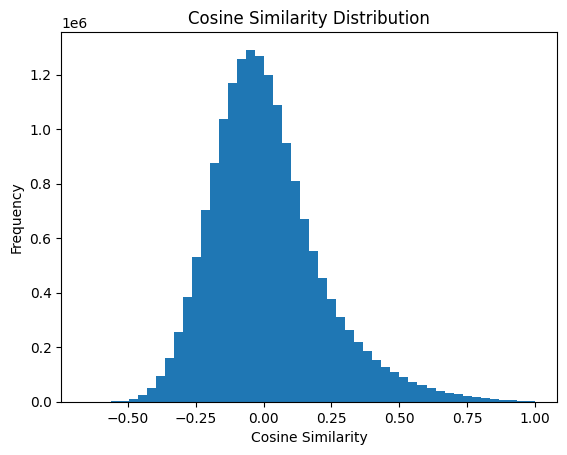

In [91]:
import matplotlib.pyplot as plt

plt.hist(flattened_similarities, bins=50)
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()